In [25]:
# Importing necessary libraries for modelling

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt


**Machine Learning Goal**
- Answer the following question: 
-- **Q1:** *What can I expect to pay for my trip to the airport?*
-- **Q2:** *What is the fastest time to the airport? (for those trying to make a plane just in the nick of time)*

Airports were the focus for this machine learning exercise, as its the location with highest frequency of travel that has the higher $ value associated with it. If you're a driver, you have the ability to earn a larger fare (to and fro from the airport), and if you're a passenger you're looking for the cheapest, and possibly the fastest ride to get to the airport. 

The models in this notebook were specifically trained with Random Forest Regressor, and were hyperparamatized to achieve the most optimal variance in the target variable on the training data. One hot encoding or scaling was not required as this a Random Forest Regressor was use (not a classification model).


In [3]:
# Reading in the data needed for modelling using parquet
# Niks workspace was modified to generate Airport specific data that this model would be built on

ny_fhvyc_df = pd.read_parquet('Resources/airport_model_df.parquet')
ny_fhvyc_df.head(20)

,service,second_of_day,day_of_year,PULocationID,DOLocationID,trip_distance,total_amount,ride_length,is_weekend,is_holiday,morning_rush_hour,evening_rush_hour,prcp,temp(f)
0,2,965,1,132,132,3.80,18.80,479.0,False,1,0,0,0.0,42.80
1,1,993,1,11,132,19.10,46.54,1491.0,False,1,0,0,0.0,42.80
2,1,8514,1,100,132,16.68,158.05,1790.0,False,1,0,0,0.0,42.08
3,1,9283,1,65,138,10.71,53.47,1214.0,False,1,0,0,0.0,42.08
4,2,9843,1,132,132,3.80,14.33,486.0,False,1,0,0,0.0,42.08
5,2,10551,1,100,132,18.38,91.48,2157.0,False,1,0,0,0.0,42.08
6,0,11359,1,230,1,20.40,118.75,1956.0,False,1,0,0,0.0,42.08
7,0,11562,1,48,1,19.63,95.70,2217.0,False,1,0,0,0.0,42.08
8,2,12029,1,219,132,3.62,15.22,467.0,False,1,0,0,0.0,42.08
9,2,12103,1,234,132,17.75,92.40,1964.0,False,1,0,0,0.0,42.08


In [4]:
# Identifying which airport is the most popular aiport for the TNC
ny_fhvyc_df.groupby(['DOLocationID']).count()


,service,second_of_day,day_of_year,PULocationID,trip_distance,total_amount,ride_length,is_weekend,is_holiday,morning_rush_hour,evening_rush_hour,prcp,temp(f)
DOLocationID,,,,,,,,,,,,,
1,34270,34270,34270,34270,34270,34270,34270,34270,34270,34270,34270,34270,34270
132,113180,113180,113180,113180,113180,113180,113180,113180,113180,113180,113180,113180,113180
138,117516,117516,117516,117516,117516,117516,117516,117516,117516,117516,117516,117516,117516


In [7]:
# The ny_fhvyc_df includes information for ALL surrounding New York Airports
# Newark = DOLocationID = 1 | JKF = 132 | LaGuadia = 138
# Creating a simple model first with only focus on ONE AIRPORT, Newark (EWR) to being with before bringing the other airports in.
# Yellow Cab (service) = 0 | Uber = 1 | Lyft = 2

ny_fhvyc_lag = ny_fhvyc_df[ny_fhvyc_df['DOLocationID'] == 138]
ny_fhvyc_lag

,service,second_of_day,day_of_year,PULocationID,DOLocationID,trip_distance,total_amount,ride_length,is_weekend,is_holiday,morning_rush_hour,evening_rush_hour,prcp,temp(f)
3,1,9283,1,65,138,10.71,53.47,1214.0,False,1,0,0,0.0,42.08
10,1,12152,1,78,138,10.29,42.09,1144.0,False,1,0,0,0.0,42.08
12,2,12607,1,230,138,14.93,57.43,2914.0,False,1,0,0,0.0,42.08
15,2,12855,1,217,138,9.40,38.41,847.0,False,1,0,0,0.0,42.08
16,0,13158,1,263,138,7.97,58.37,818.0,False,1,0,0,0.0,42.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264930,2,64705,366,162,138,11.25,51.40,1382.0,False,0,0,1,0.0,51.98
264943,0,67795,366,138,138,2.35,31.53,792.0,False,0,0,1,0.0,51.98
264944,2,67938,366,244,138,8.91,51.16,1384.0,False,0,0,1,0.0,51.98
264948,2,70240,366,145,138,6.66,31.25,1123.0,False,0,0,0,0.0,53.06


In [8]:
# Checking to see data if non null values are present
ny_fhvyc_lag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117516 entries, 3 to 264954
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   service            117516 non-null  int64  
 1   second_of_day      117516 non-null  int32  
 2   day_of_year        117516 non-null  int32  
 3   PULocationID       117516 non-null  int32  
 4   DOLocationID       117516 non-null  int32  
 5   trip_distance      117516 non-null  float64
 6   total_amount       117516 non-null  float64
 7   ride_length        117516 non-null  float64
 8   is_weekend         117516 non-null  bool   
 9   is_holiday         117516 non-null  int64  
 10  morning_rush_hour  117516 non-null  int64  
 11  evening_rush_hour  117516 non-null  int64  
 12  prcp               117516 non-null  float64
 13  temp(f)            117516 non-null  float64
dtypes: bool(1), float64(5), int32(4), int64(4)
memory usage: 10.9 MB


In [9]:
#Trying to plot and see if the data makes sense, ie what is the average total fare paid by
# each transport network company provider (Yellow cab, Uber,Lyft) to the airport
tnc_grouped_df = ny_fhvyc_lag.groupby(['service','day_of_year'])
avg_total_fare_df = tnc_grouped_df['total_amount'].mean()
print(avg_total_fare_df)


service  day_of_year
0        1              65.520244
         2              68.069189
         3              59.286296
         4              71.362857
         5              65.611628
                          ...    
2        362            47.804965
         363            45.989167
         364            45.913393
         365            44.163364
         366            46.948444
Name: total_amount, Length: 1036, dtype: float64


In [10]:
avg_fare_df = pd.DataFrame(avg_total_fare_df).reset_index()
avg_fare_df = avg_fare_df.rename(columns={'total_amount': 'avg fare'})
avg_fare_df

,service,day_of_year,avg fare
0,0,1,65.520244
1,0,2,68.069189
2,0,3,59.286296
3,0,4,71.362857
4,0,5,65.611628
...,...,...,...
1031,2,362,47.804965
1032,2,363,45.989167
1033,2,364,45.913393
1034,2,365,44.163364


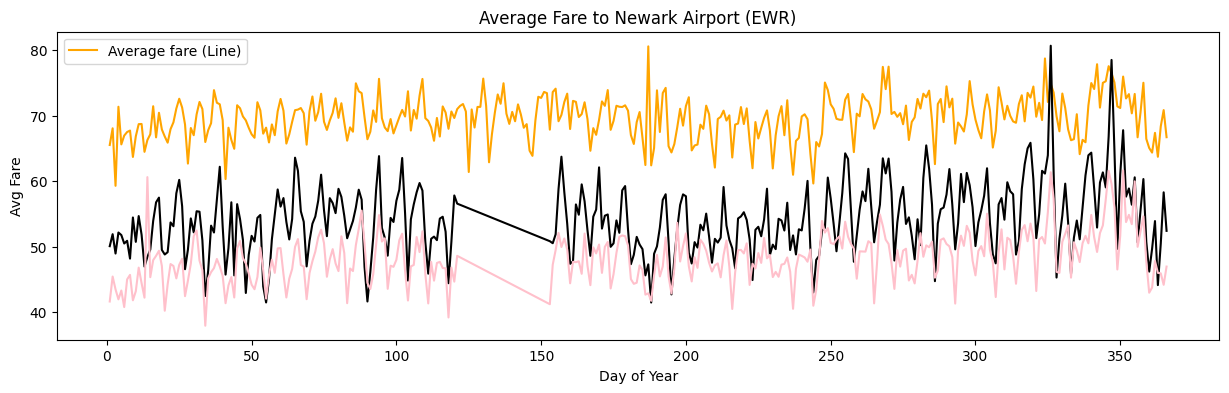

In [11]:
#Plotting to see what average fares look like to LaGuadia Airport
yc_avg = avg_fare_df[avg_fare_df['service'] == 0]
uber_avg = avg_fare_df[avg_fare_df['service'] == 1]
lyft_avg = avg_fare_df[avg_fare_df['service'] == 2]

fig1, ax = plt.subplots()

# Plot the line chart for Yellow Cab
yc_avg.plot(x='day_of_year', y='avg fare', kind='line', figsize=(15,4), color='orange', ax=ax) 

# Plot the line chart for Uber
uber_avg.plot(x='day_of_year', y='avg fare', kind='line', figsize=(15,4), color='black', ax=ax) 

# Plot the line chart for lyft
lyft_avg.plot(x='day_of_year', y='avg fare', kind='line', figsize=(15,4), color='pink', ax=ax) 

# Customize the plot (optional)
plt.xlabel('Day of Year')
plt.ylabel('Avg Fare')
plt.title('Average Fare to Newark Airport (EWR)')
plt.legend(['Average fare (Line)'])
plt.show()


Plot shows that Yellow Cab is more expensive, followed by Lyft being the most cheapest ride option to take. 

NOTE: In May 2024 Uber and Lyft implemented 'lockouts', a policy to restrict access the app to driver, to manipulate driver pay and fight policies being put on them to instill minimumn driver payouts. That is the drop in rides reflected here in the chart.

In [12]:
#Trying to understand now which TNC is the fastest by average to get users to the airport (LAG)
avg_time = tnc_grouped_df['ride_length'].mean()
avg_time_df = pd.DataFrame(avg_time).reset_index()
avg_time_df

,service,day_of_year,ride_length
0,0,1,1265.682927
1,0,2,1711.702703
2,0,3,1324.444444
3,0,4,1630.228571
4,0,5,1564.744186
...,...,...,...
1031,2,362,1459.580420
1032,2,363,1406.458333
1033,2,364,1314.500000
1034,2,365,1380.127273


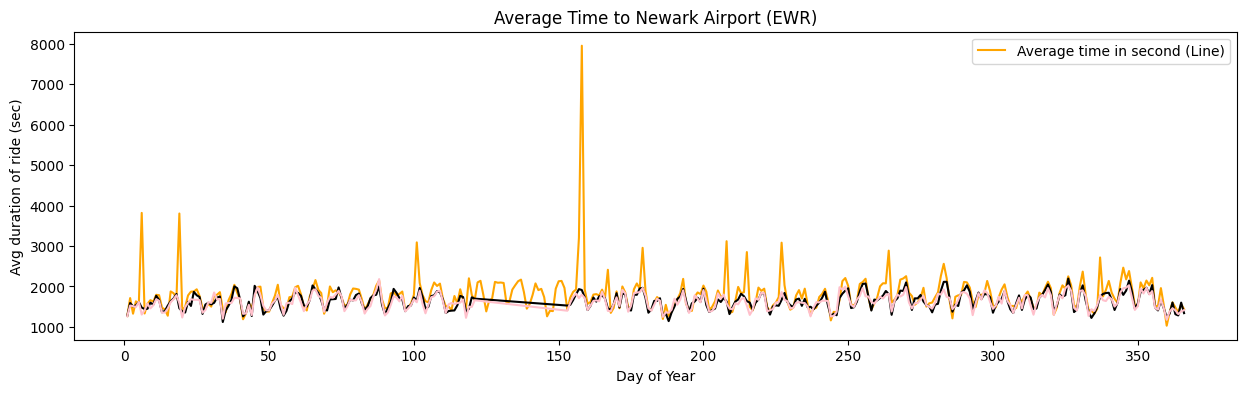

In [16]:
# Plotting to see what the average time to the airport takes
yc_avg_time = avg_time_df[avg_time_df['service'] == 0]
uber_avg_time = avg_time_df[avg_time_df['service'] ==1]
lyft_avg_time = avg_time_df[avg_time_df['service'] ==2]


fig1, ax = plt.subplots()

# Plot the line chart for Yellow Cab
yc_avg_time.plot(x='day_of_year', y='ride_length', kind='line', figsize=(15,4), color='orange', ax=ax) 

# Plot the line chart for Uber
uber_avg_time.plot(x='day_of_year', y='ride_length', kind='line', figsize=(15,4), color='black', ax=ax) 

# Plot the line chart for lyft
lyft_avg_time.plot(x='day_of_year', y='ride_length', kind='line', figsize=(15,4), color='pink', ax=ax) 

# Customize the plot (optional)
plt.xlabel('Day of Year')
plt.ylabel('Avg duration of ride (sec)')
plt.title('Average Time to Newark Airport (EWR)')
plt.legend(['Average time in second (Line)'])
plt.show()



This definitley goes against my hypothesis that YC drivers would take longer to get passengers to the airport, given that they are legacy drivers who earned their licenses based on city knowledge and inner roads in comparision to the novice drivers that influxed with the For Hire Vehicle services (FHV's: Uber, Lyft). 

Plot shows that for rides on the same day, Yellow Cab ride are def longer, whereas rides in FHV's (Uber, Lyft), are quite close in their performance. 

In [17]:
# Investigating what values are present during the drop, for specifically uber / lyft a
# Will probably need to drop corresponding Yellow Cab data during the period to train models 

uber_lockout_data = ny_fhvyc_lag.loc[ny_fhvyc_lag['service'] == 1]
uber_lockout_data_2 = uber_lockout_data.loc[(uber_lockout_data['day_of_year']> 121) & (uber_lockout_data['day_of_year']< 153)]
print(uber_lockout_data_2)

# Confirming if this is the same for lyft
lyft_lockout_data = ny_fhvyc_lag.loc[ny_fhvyc_lag['service'] == 2]
lyft_lockout_data_2 = lyft_lockout_data.loc[(lyft_lockout_data['day_of_year']> 121) & (lyft_lockout_data['day_of_year']< 153)]
print(lyft_lockout_data_2)

Empty DataFrame
Columns: [service, second_of_day, day_of_year, PULocationID, DOLocationID, trip_distance, total_amount, ride_length, is_weekend, is_holiday, morning_rush_hour, evening_rush_hour, prcp, temp(f)]
Index: []
Empty DataFrame
Columns: [service, second_of_day, day_of_year, PULocationID, DOLocationID, trip_distance, total_amount, ride_length, is_weekend, is_holiday, morning_rush_hour, evening_rush_hour, prcp, temp(f)]
Index: []


In [18]:
# Need to drop the records for Yellow Cab between these days in the entire dataset for training the model 
# Indexes 100321:105236 need to be dropped
ny_tnc_filtered = ny_fhvyc_df.drop(ny_fhvyc_df.index[100321:105236])
ny_tnc_filtered.head(5)
ny_tnc_filtered.info()

# THIS DATASET CAN NOW BE USED TO TRAIN AS ITS BALANCED 


<class 'pandas.core.frame.DataFrame'>
Index: 260051 entries, 0 to 264965
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   service            260051 non-null  int64  
 1   second_of_day      260051 non-null  int32  
 2   day_of_year        260051 non-null  int32  
 3   PULocationID       260051 non-null  int32  
 4   DOLocationID       260051 non-null  int32  
 5   trip_distance      260051 non-null  float64
 6   total_amount       260051 non-null  float64
 7   ride_length        260051 non-null  float64
 8   is_weekend         260051 non-null  bool   
 9   is_holiday         260051 non-null  int64  
 10  morning_rush_hour  260051 non-null  int64  
 11  evening_rush_hour  260051 non-null  int64  
 12  prcp               260051 non-null  float64
 13  temp(f)            260051 non-null  float64
dtypes: bool(1), float64(5), int32(4), int64(4)
memory usage: 24.1 MB


In [19]:
# REFILTERING LaGuadia airport only
ny_tnc_lag = ny_tnc_filtered[ny_tnc_filtered['DOLocationID'] == 138]
ny_tnc_lag.head(5)

,service,second_of_day,day_of_year,PULocationID,DOLocationID,trip_distance,total_amount,ride_length,is_weekend,is_holiday,morning_rush_hour,evening_rush_hour,prcp,temp(f)
3,1,9283,1,65,138,10.71,53.47,1214.0,False,1,0,0,0.0,42.08
10,1,12152,1,78,138,10.29,42.09,1144.0,False,1,0,0,0.0,42.08
12,2,12607,1,230,138,14.93,57.43,2914.0,False,1,0,0,0.0,42.08
15,2,12855,1,217,138,9.40,38.41,847.0,False,1,0,0,0.0,42.08
16,0,13158,1,263,138,7.97,58.37,818.0,False,1,0,0,0.0,42.08


In [20]:
###################################################################################################### 
# MODEL ONE: PRICE 
######################################################################################################

# Modelling for Price: What can a passenger expect to pay from NYC (5 areas) to LaGuadia??
# Setting 'Total Amount' as the target and everything else as a feature
X = ny_tnc_lag.drop(['total_amount'], axis=1)
y = ny_tnc_lag['total_amount']

In [21]:
# Splitting the data in to test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

# Scale data, even though its technically not needed for Tree models such as RandomForest, 
# Incase I plan to use KNR, I wont have to mess with the data again (apples to apples compare)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Lets create and train the Random Forest Regressor Model
# Also going to try to find which depth gives the best accuracy score

rfr = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0) #n_estimators is the number of trees.

# Train the model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

In [23]:
# Prediction
y_pred = rfr.predict(X_test)

In [24]:
# Evaluating the models post training
print(f'Training Score: {rfr.score(X_train, y_train)}')
print(f'Testing Score: {rfr.score(X_test, y_test)}')

# Scoring the Models ability
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

Training Score: 0.6430502518139163
Testing Score: 0.6377683626823909
RMSE: 13.04626375486311
R-squared: 0.6377683626823909


While train vs. test is close, ie model is not over fitting, and the average magnitude of my error (RMSE) is ~13 units away from actual values, I think the model can be tuned further. 
- Reducing features by identifying which ones are important 
- Tuning parameters of the model to identify the right parameters

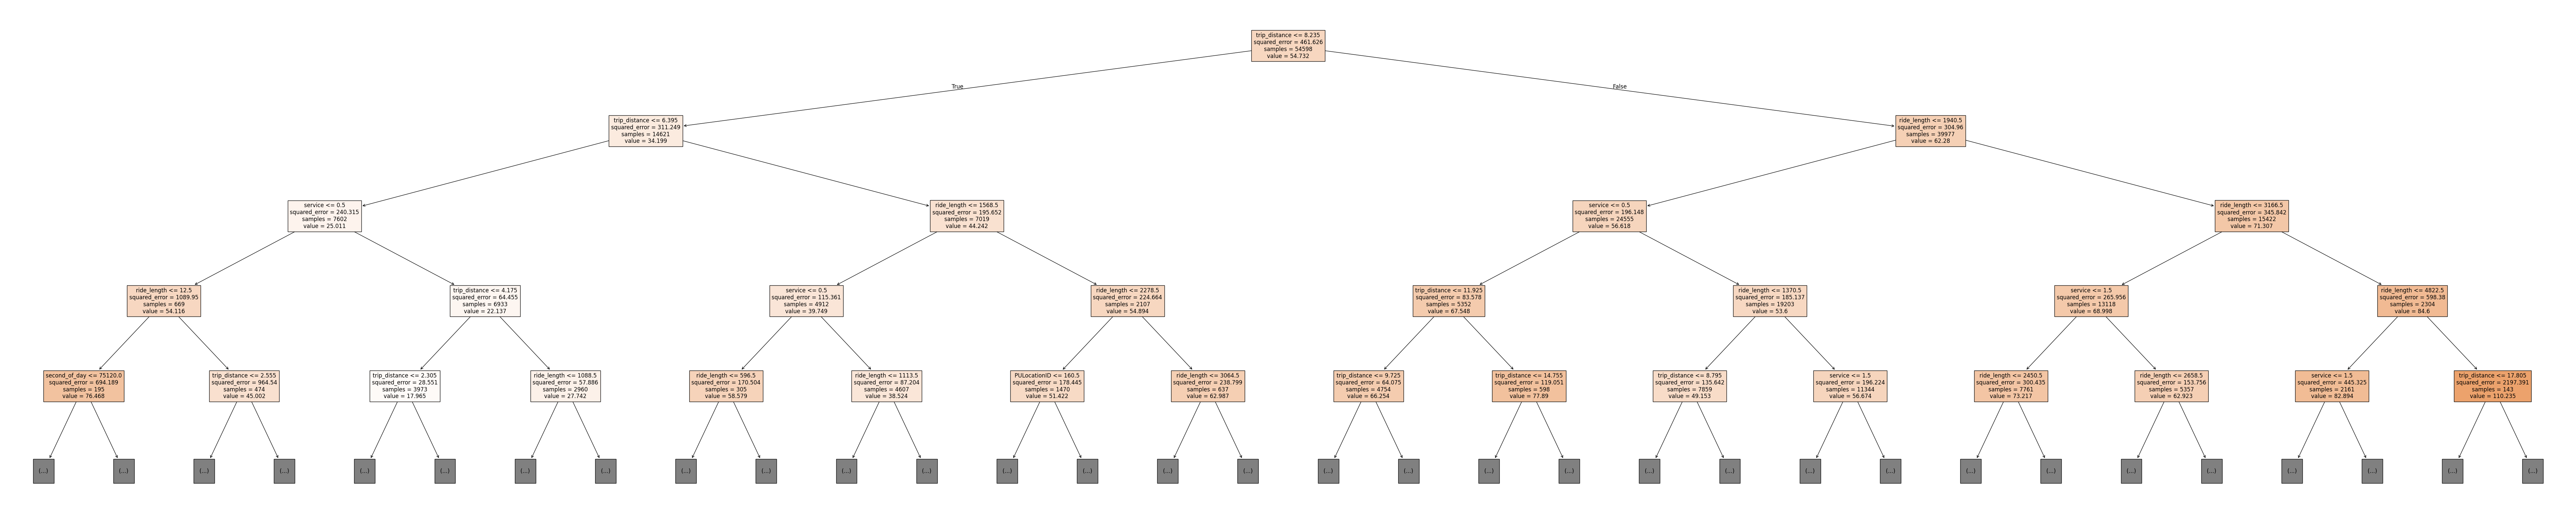

In [26]:
# Lets try to plot the decision tree so I can kinda see what its doing
plt.figure(figsize=(100,20))
model1_tree = tree.plot_tree(rfr.estimators_[50], feature_names=X.columns, filled=True, max_depth=4)

In [159]:
# Lets try to identify which features are important using gini 
feature_importances = pd.DataFrame({'Feature': X.columns, 'Gini Importance':rfr.feature_importances_}
                                   ).sort_values('Gini Importance', ascending=False) 

print(feature_importances)

              Feature  Gini Importance
5       trip_distance         0.632374
6         ride_length         0.240275
0             service         0.122795
3        PULocationID         0.001615
1       second_of_day         0.001441
12            temp(f)         0.001284
2         day_of_year         0.000166
7          is_weekend         0.000025
9   morning_rush_hour         0.000011
11               prcp         0.000009
10  evening_rush_hour         0.000004
4        DOLocationID         0.000000
8          is_holiday         0.000000


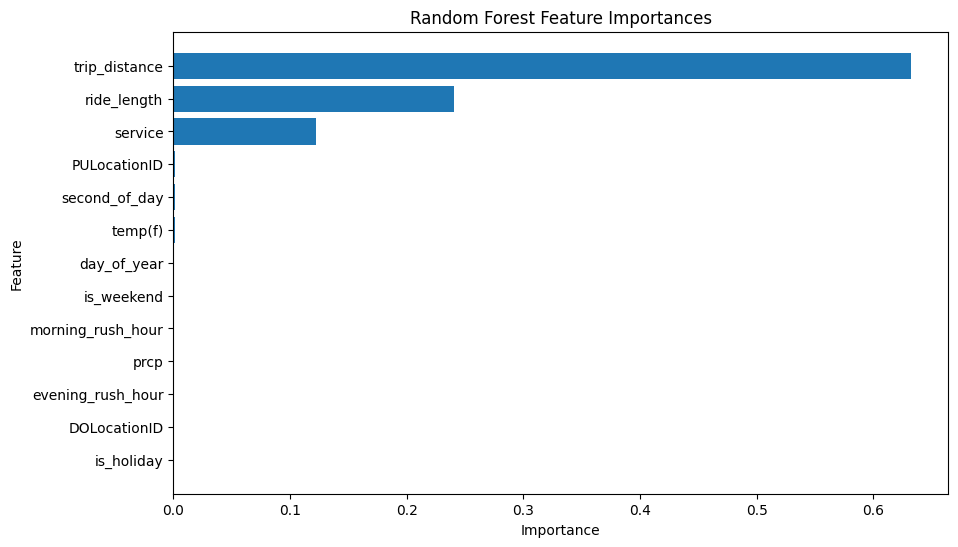

In [161]:
# Display Importances as a plot:
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'], feature_importances['Gini Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis() # To display most important at the top.
plt.show()

In [163]:
ny_tnc_lag.columns

Index(['service', 'second_of_day', 'day_of_year', 'PULocationID',
       'DOLocationID', 'trip_distance', 'total_amount', 'ride_length',
       'is_weekend', 'is_holiday', 'morning_rush_hour', 'evening_rush_hour',
       'prcp', 'temp(f)'],
      dtype='object')

In [187]:
# Checking to see if MODEL ONE: PRICE score improves with just these features 
X2 = ny_tnc_lag.drop(['second_of_day', 'day_of_year','DOLocationID','is_weekend',
                       'is_holiday', 'morning_rush_hour', 'evening_rush_hour',
                       'prcp', 'temp(f)', 'total_amount'], axis=1)
y = ny_tnc_lag['total_amount']


In [188]:
# Creating new train, test, split with these features to compare
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=42)

In [189]:
# Training data with same parameters to see if importance plays a role
rfr2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0) 

# Train the model
rfr2.fit(X2_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

In [190]:
# Prediction
y_pred2 = rfr2.predict(X2_test)

In [191]:
# Evaluating the models post training with SELECT FEATURES ONLY
print(f'Training Score w/ ALL features: {rfr.score(X_train, y_train)}')
print(f'Testing Score w/ ALL features: {rfr.score(X_test, y_test)}')
print('\n')
print(f'Training Score on select features: {rfr2.score(X2_train, y_train)}')
print(f'Testing Score on select features: {rfr2.score(X2_test, y_test)}')
print('\n')

# Scoring the Models ability pre importance
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')
print('\n')

# Scoring the Models ability post importance
rmse_imp = root_mean_squared_error(y_test, y_pred2)
r2_imp = r2_score(y_test, y_pred2)
print(f'RMSE w/ Select Features: {rmse_imp}')
print(f'R-squared w/ Select Features: {r2_imp}')

Training Score w/ ALL features: 0.6395521336868413
Testing Score w/ ALL features: 0.6483376630833864


Training Score on select features: 0.6414113067819491
Testing Score on select features: 0.6447370690068496


RMSE: 11.175615657608484
R-squared: 0.7309921629317317


RMSE w/ Select Features: 12.84292476504666
R-squared w/ Select Features: 0.6447370690068496


So, looks like features do not matter, as the one with ALL features is slightly higher

In [185]:
# Lets search for the best parameters for the Random forest model with these..
# ..specific parameters to start with across the LaGuadia dataset
param_dist = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'max_samples': [None, 0.5]
}

# Creating a clean Random Forest Regressor to use
rfr_best = RandomForestRegressor(random_state=69)

# Using RandomizedSearch to find best parameters
random_search = RandomizedSearchCV(rfr_best,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=3,
                                   verbose=2,
                                   random_state=69,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error'
                                   )

# fit the random search to LaGuadia Data
random_search.fit(X_train, y_train)

# Best Parameters
best_rf = random_search.best_estimator_
best_params = random_search.best_params_

print(f'The best parameters to use: {best_params}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=15, max_features=auto, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, max_samples=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  23.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_samples=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_samples=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_samples=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_samples=0.5, 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
53 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pa

The best parameters to use: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


The best parameters to use: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

In [226]:
# HYPERPARAMETERS ON FULL DATA SET
# Revising the model with these hyperparameters on the entire airport dataset
X = ny_tnc_filtered.drop(['total_amount'], axis=1)
y = ny_tnc_filtered['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

rfr_hy_p = RandomForestRegressor(n_estimators=200,
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_samples= None,
                            max_features='sqrt',
                            max_depth= None,
                            random_state=0) 

rfr_hy_p.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=200,
                      random_state=0)

In [227]:
# Hyper Based Prediction
y_pred_hy_p = rfr_hy_p.predict(X_test)

In [201]:
# Evaluating the models post training
print(f'Training Score with Hyperparameters tuned: {rfr_hy_p.score(X_train, y_train)}')
print(f'Testing Score with Hyperparameters tuned: {rfr_hy_p.score(X_test, y_test)}')

# Scoring the Models ability
rmse = root_mean_squared_error(y_test, y_pred_hy_p)
r2 = r2_score(y_test, y_pred_hy_p)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

Training Score with Hyperparameters tuned: 0.9294661057016015
Testing Score with Hyperparameters tuned: 0.8045972448871969
RMSE: 14.76655782856976
R-squared: 0.8045972448871969


In [218]:
###################################################################################################### 
# MODEL TWO: DURATION 
######################################################################################################

# Modelling for Duration: Whats the fastest ride a passenger can get from NYC (5 areas) to Surrounding airports??
# Setting 'Total Amount' and 'Total' as the target and everything else as a feature
X = ny_tnc_filtered.drop(['ride_length', 'total_amount'], axis=1)
y = ny_tnc_filtered['ride_length']


In [228]:
# Need to obtain new hyperparameters based on the new dataset (different target and features)
# Lets search for the best parameters for the Random forest model with these..

param_dist = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'max_samples': [None, 0.5]
}

# Creating a clean Random Forest Regressor to use
rfr_best_d = RandomForestRegressor(random_state=69)

# Using RandomizedSearch to find best parameters
random_search = RandomizedSearchCV(rfr_best,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=3,
                                   verbose=2,
                                   random_state=69,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error'
                                   )

# fit the random search to LaGuadia Data
random_search.fit(X_train, y_train)

# Best Parameters
best_rf_d = random_search.best_estimator_
best_params = random_search.best_params_

print(f'The best parameters to use: {best_params}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=15, max_features=auto, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=T

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.8min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.8min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, max_samples=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_samples=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_samp

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

The best parameters to use: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


The best parameters to use: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

In [229]:
# Using the same hyper parameters as above:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

rfr_hy_d = RandomForestRegressor(n_estimators=100,
                            min_samples_split=5,
                            min_samples_leaf=4,
                            max_samples= None,
                            max_features='sqrt',
                            max_depth= None,
                            random_state=0) 

rfr_hy_d.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, random_state=0)

In [230]:
# Hyper Based Prediction
y_pred_hy_d = rfr_hy_d.predict(X_test)

In [231]:
# Evaluating the models post training
print(f'Training Score with Hyperparameters tuned: {rfr_hy_d.score(X_train, y_train)}')
print(f'Testing Score with Hyperparameters tuned: {rfr_hy_d.score(X_test, y_test)}')

# Scoring the Models ability
rmse = root_mean_squared_error(y_test, y_pred_hy_d)
r2 = r2_score(y_test, y_pred_hy_d)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

Training Score with Hyperparameters tuned: 0.883931202195154
Testing Score with Hyperparameters tuned: 0.8008997947384598
RMSE: 14.905610998629884
R-squared: 0.8008997947384598
